# Search: Solving a Maze Using a Goal-based Agent

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for planning paths through mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

In this exercise, we will implement the planning function for a type of goal-based agent called a __planning agent__. The planning function uses a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. We will only focus on the planning function, so you do not need to implement an environment, just use the map to search for a path to solve the maze. 

Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the plan step-by-step and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. I will show you a short example, but you do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [1]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [2]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

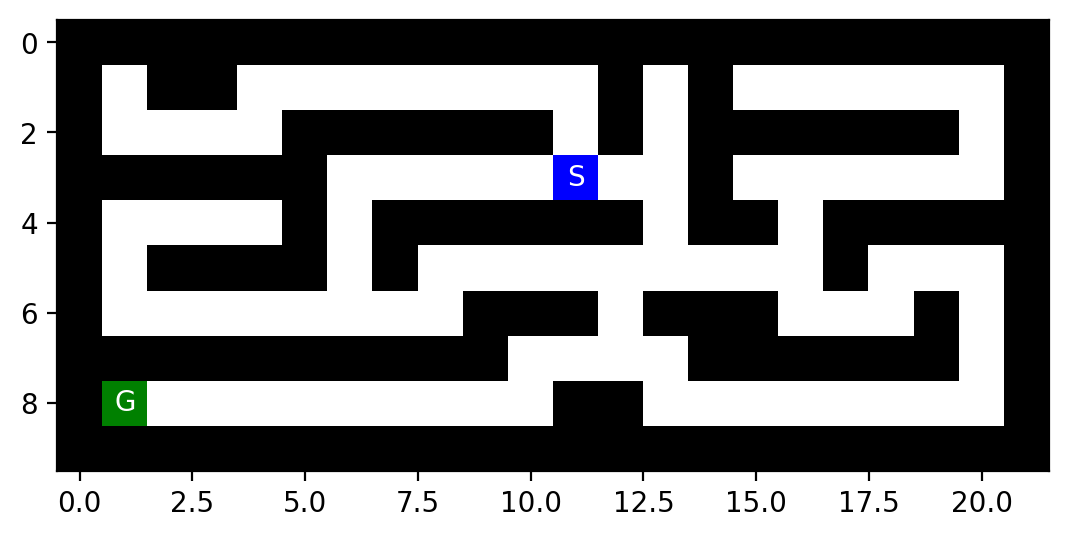

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [5]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## An Example for a Planning Agent

I will show you here how to implement a simple agent that uses a random plan. It will not solve the maze, but show you how the mechanics work.

First, we define a generic planning agent that fist plans, and then executes the plan step-by-step. 

In [6]:
class Planning_Agent:
    def __init__(self, maze, start, goal, planning_function):
        self.maze = maze
        self.start = start
        self.goal = goal
        self.planning_function = planning_function
        self.plan = None
        self.progress = None

    def act(self):
        # plan if no plan exists
        if self.plan is None:
            print("Planning...")
            self.plan = self.planning_function(self.maze, self.start, self.goal)
            self.progress = 0
        
        # check if plan is completed
        if self.progress >= len(self.plan):        
            raise Exception("Completed Plan. No more planned actions")
        
        # follow the plan
        action = self.plan[self.progress]
        print(f"Following plan... step {self.progress}: {action}")

        self.progress += 1
        return action

Next, we define the planning function. This function is what you will implement in this assignment.  

In [7]:
import numpy as np

def plan_random(maze, start, goal):
    """Create a random plan with 10 steps"""
    plan = np.random.choice(["N", "E", "S", "W"], size=10, replace=True).tolist()
    return plan

plan_random(maze, (1,1), (8,8))

['E', 'N', 'S', 'N', 'W', 'E', 'E', 'N', 'S', 'N']

This planning function is not great and will not produce a plan that solves the maze. Your planning functions will do better.

Finally, we can create the planning agent, give it the planning function and implement a simple environment that asks it 11 times for an action.

In [8]:
my_agent = Planning_Agent(maze, mh.find_pos(maze, what = "S"), mh.find_pos(maze, what = "G"), plan_random)

def environment(agent_function, steps):
    for _ in range(steps):
        try:
            agent_function()
        except Exception as e:
            print(f"Agent exception: {e}")

environment(my_agent.act, steps=11)

Planning...
Following plan... step 0: N
Following plan... step 1: N
Following plan... step 2: S
Following plan... step 3: E
Following plan... step 4: N
Following plan... step 5: S
Following plan... step 6: N
Following plan... step 7: S
Following plan... step 8: W
Following plan... step 9: E
Agent exception: Completed Plan. No more planned actions


Note: The agent and environment implementation above is just an illustration. You will only implement and experiment with different versions of the planning function.

## Tree structure

To use tree search, you will need to implement a tree data structure in Python. 
Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [9]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

## Task 1: Xác định bài toán tìm kiếm và ước lượng kích thước

### Các thành phần của bài toán tìm kiếm

- **Trạng thái ban đầu (Initial state):**  
  Agent bắt đầu tại vị trí xuất phát S (tọa độ hàng, cột).

- **Hành động (Actions):**  
  Các hành động hợp lệ mà agent có thể thực hiện: đi lên, đi xuống, đi sang trái, đi sang phải.  
  Nếu được phép, có thể mở rộng thêm đi chéo.

- **Mô hình chuyển trạng thái (Transition model):**  
  Nếu agent đang ở trạng thái (x, y) và thực hiện một hành động hợp lệ, thì sẽ chuyển sang một trạng thái mới (x', y') miễn là ô đó không phải tường và nằm trong phạm vi mê cung.  
  Ví dụ: từ (x, y) đi sang trái thì thành (x, y-1).

- **Trạng thái đích (Goal state):**  
  Vị trí G mà agent cần đến để thoát mê cung.

- **Chi phí đường đi (Path cost):**  
  Tổng số bước di chuyển từ S đến G.  
  Mỗi bước di chuyển có chi phí bằng 1, nên path cost chính là độ dài đường đi.

In [ ]:
# Your answer goes here


Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

### Ước lượng kích thước bài toán

- **n (kích thước không gian trạng thái):**  
  Là số ô trống trong mê cung (không phải tường).  
  Có thể tính bằng cách duyệt toàn bộ mê cung và đếm số ô có thể đi được.

- **d (độ sâu nghiệm tối ưu):**  
  Là số bước đi trong đường đi ngắn nhất từ S đến G.  
  Có thể tính chính xác bằng thuật toán BFS (với chi phí mỗi bước bằng 1).  
  Nếu không tìm thấy đường đi thì d = vô hạn.

- **m (độ sâu tối đa của cây tìm kiếm):**  
  Là độ dài đường đi dài nhất có thể trong cây tìm kiếm (không lặp lại trạng thái).  
  Giới hạn trên: m ≤ n - 1 (vì không thể đi qua nhiều hơn số ô trống).  
  Với mê cung nhỏ có thể tìm gần đúng bằng DFS/backtracking, với mê cung lớn thì chỉ dùng ước lượng.

- **b (hệ số phân nhánh tối đa):**  
  Là số hành động tối đa có thể thực hiện từ một trạng thái.  
  Với di chuyển 4 hướng thì b ≤ 4.  
  Có thể xác định bằng cách duyệt qua từng ô trống, đếm số ô kề có thể đi tới, rồi lấy giá trị lớn nhất.

In [85]:
# Your answer goes here

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [10]:
class Maze:
    def __init__(self, grid, start, goal):
        self.grid = grid              # ma trận: 0 = đường, 1 = tường
        self.start = start            # tọa độ bắt đầu (x, y)
        self.goal = goal              # tọa độ đích (x, y)
        self.nrows = len(grid)        # số hàng
        self.ncols = len(grid[0])     # số cột

    def is_wall(self, x, y):
        return self.grid[x][y] == 1   # kiểm tra có phải tường

    def show(self):
        for i in range(self.nrows):
            row = ""
            for j in range(self.ncols):
                if (i, j) == self.start:
                    row += "S "
                elif (i, j) == self.goal:
                    row += "G "
                elif self.grid[i][j] == 1:
                    row += "# "
                else:
                    row += ". "
            print(row)

    def show_path(self, path):
        path_set = set(path)
        for i in range(self.nrows):
            row = ""
            for j in range(self.ncols):
                if (i, j) == self.start:
                    row += "S "
                elif (i, j) == self.goal:
                    row += "G "
                elif (i, j) in path_set:
                    row += "o "
                elif self.grid[i][j] == 1:
                    row += "# "
                else:
                    row += ". "
            print(row)


Start: (3, 11) Goal: (8, 1)


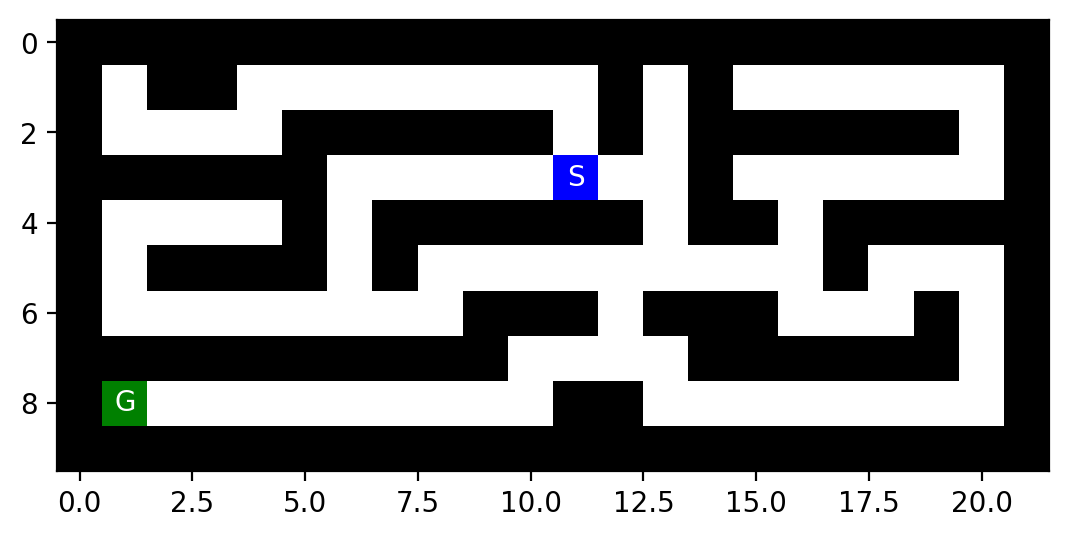

BFS path length: 20
DFS path length: 50
=== BFS Result ===


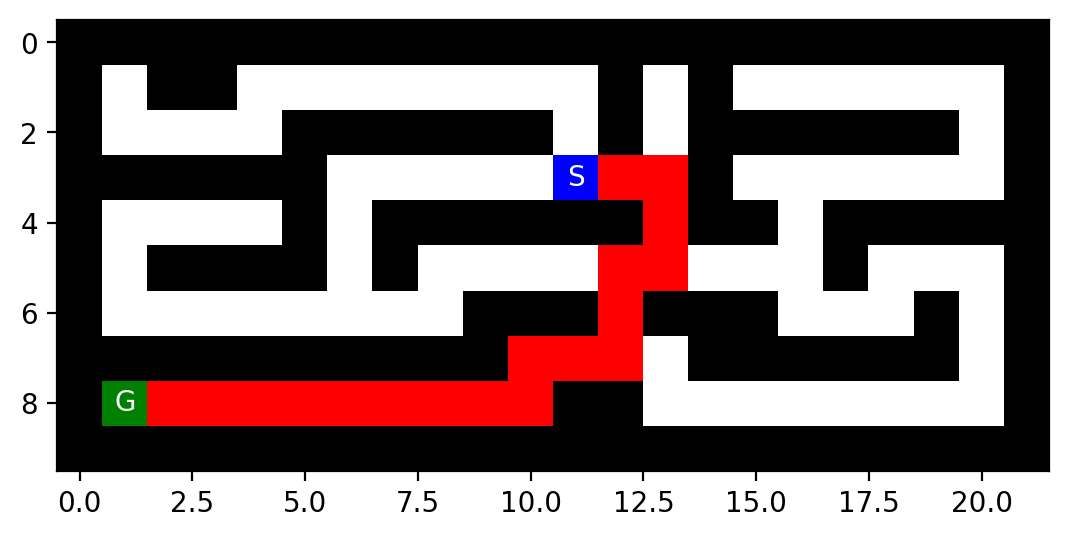

=== DFS Result ===


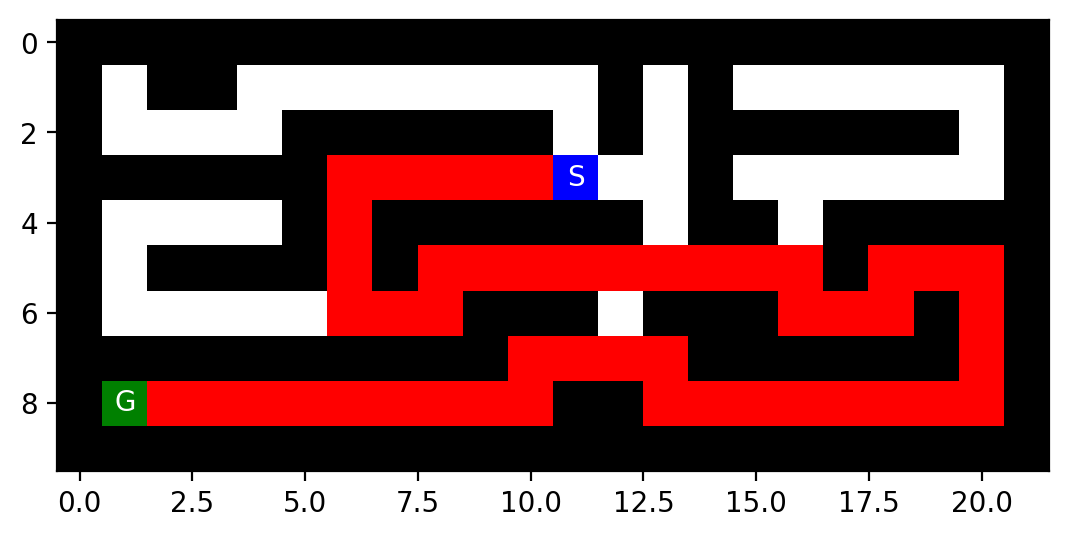

In [15]:
import maze_helper as mh
from collections import deque
import numpy as np

# ==== HÀM HỖ TRỢ ====

# Lấy các hàng xóm hợp lệ (không phải tường)
def get_neighbors(state, maze):
    x, y = state
    moves = [(1,0), (-1,0), (0,1), (0,-1)]  # 4 hướng
    neighbors = []
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1]:
            if maze[nx, ny] != "X":   # không phải tường
                neighbors.append((nx, ny))
    return neighbors

def is_goal(state, goal):
    return state == goal

# Đánh dấu đường đi trên maze để hiển thị
def mark_path(maze, path):
    maze_copy = np.copy(maze)
    for (x, y) in path[1:-1]:  # bỏ start và goal
        maze_copy[x, y] = "P"
    return maze_copy

# ==== BFS ====
def bfs(initial_state, goal_test, successors):
    frontier = deque([initial_state])
    reached = {initial_state}
    parent = {initial_state: None}

    while frontier:
        state = frontier.popleft()
        if goal_test(state):
            # reconstruct path
            path = []
            while state is not None:
                path.append(state)
                state = parent[state]
            return list(reversed(path))

        for child in successors(state):
            if child not in reached:
                reached.add(child)
                parent[child] = state
                frontier.append(child)
    return None

# ==== DFS ====
def dfs(initial_state, goal_test, successors, max_depth=1000):
    stack = [(initial_state, [initial_state])]

    while stack:
        state, path = stack.pop()
        if goal_test(state):
            return path

        if len(path) < max_depth:
            for child in successors(state):
                if child not in path:  # tránh chu kỳ
                    stack.append((child, path + [child]))
    return None


# ==== CHẠY VỚI MAZE CÓ SẴN ====

# 1. Đọc maze từ file txt
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)

# 2. Xác định start và goal
start = tuple(map(int, mh.find_pos(maze, "S")))
goal = tuple(map(int, mh.find_pos(maze, "G")))


print("Start:", start, "Goal:", goal)
mh.show_maze(maze)

# 3. Chạy BFS và DFS
path_bfs = bfs(start, lambda s: is_goal(s, goal), lambda s: get_neighbors(s, maze))
path_dfs = dfs(start, lambda s: is_goal(s, goal), lambda s: get_neighbors(s, maze))

print("BFS path length:", len(path_bfs) if path_bfs else None)
print("DFS path length:", len(path_dfs) if path_dfs else None)

# 4. Hiển thị kết quả
if path_bfs:
    print("=== BFS Result ===")
    mh.show_maze(mark_path(maze, path_bfs))

if path_dfs:
    print("=== DFS Result ===")
    mh.show_maze(mark_path(maze, path_dfs))


How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

In [87]:
# Discussion

Discussion:

- BFS nếu không dùng reached (visited) sẽ có thể thêm cùng một trạng thái nhiều lần vào frontier. Trong đồ thị hoặc mê cung có vòng lặp, BFS sẽ lặp vô tận và không bao giờ dừng.

- DFS nếu không có reached cũng dễ bị vòng lặp hơn, vì DFS đi sâu xuống một nhánh. Nếu gặp chu kỳ thì DFS có thể bị kẹt trong vòng lặp vô hạn.

- Cách khắc phục: 
  + Với BFS thường dùng reached để ghi nhớ các node đã thăm. 
  + Với DFS có thể kiểm tra chu kỳ trong path hiện tại để không quay lại node đã thăm.


Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [88]:
# Discussion

Discussion:

- BFS:
  + Complete (nếu có lời giải thì chắc chắn tìm ra).
  + Optimal khi chi phí mỗi bước = 1, vì nó tìm được lời giải ngắn nhất.
  + Time complexity: O(b^d), với b là branching factor, d là độ sâu nghiệm tối ưu.
  + Space complexity: O(b^d), phải lưu toàn bộ frontier và reached.

- DFS:
  + Không complete trong đồ thị có chu kỳ (có thể bị kẹt vô hạn). Nếu đồ thị hữu hạn và có kiểm tra chu kỳ thì complete.
  + Không optimal, vì có thể tìm ra lời giải dài hơn trong khi tồn tại lời giải ngắn hơn.
  + Time complexity: O(b^m), với m là độ sâu tối đa của cây tìm kiếm.
  + Space complexity: O(b*m), chỉ cần lưu đường đi hiện tại và vài node, nên tiết kiệm bộ nhớ hơn BFS.

- So sánh:
  + BFS: đảm bảo tìm lời giải ngắn nhất nhưng tốn nhiều bộ nhớ.
  + DFS: tiết kiệm bộ nhớ, nhưng không đảm bảo optimal và có thể không complete nếu không xử lý chu kỳ.


## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

Start: (3, 11) Goal: (8, 1)


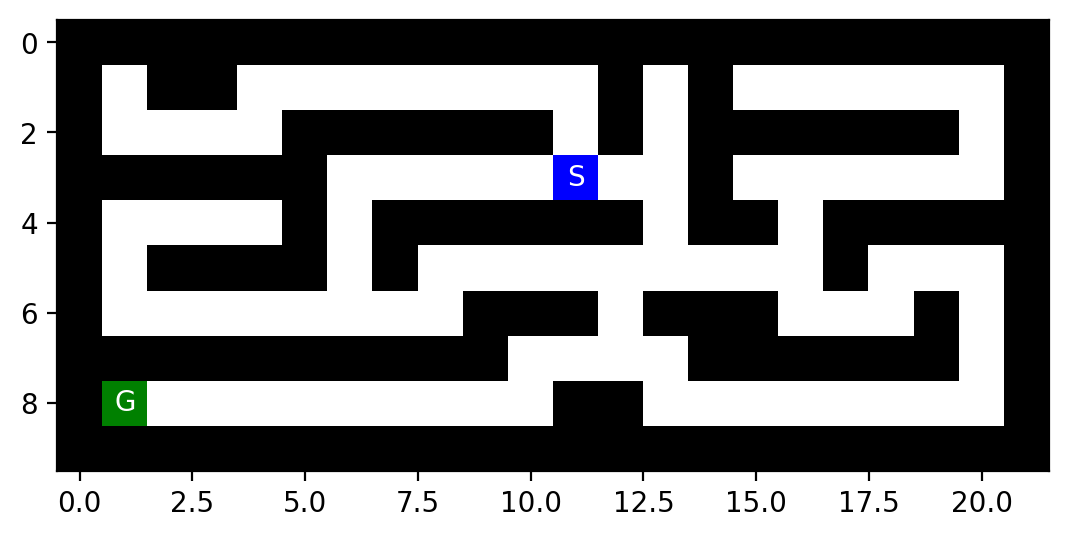

Greedy Best-First path length: 30
A* path length: 20
=== Greedy Best-First ===


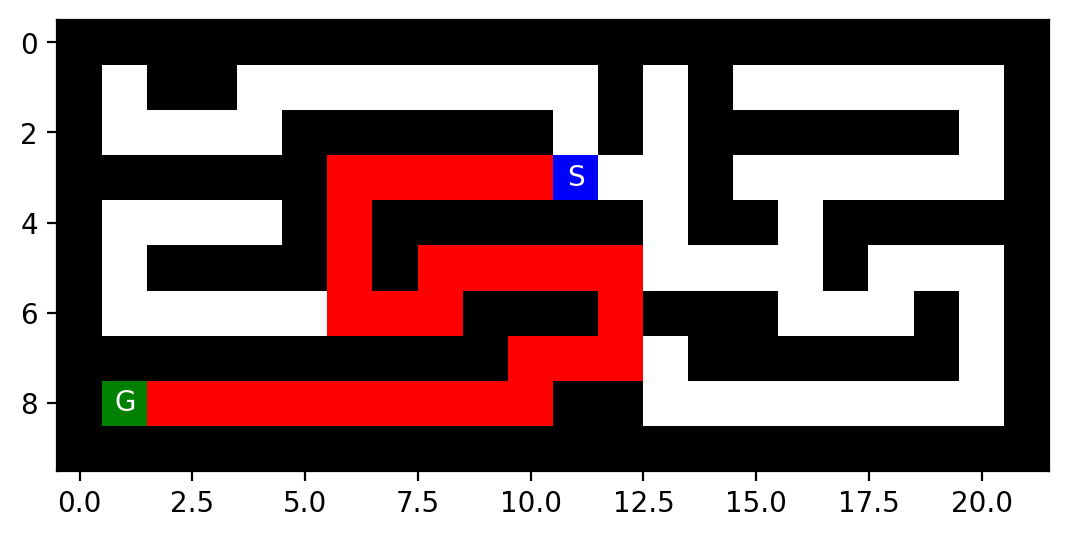

=== A* Search ===


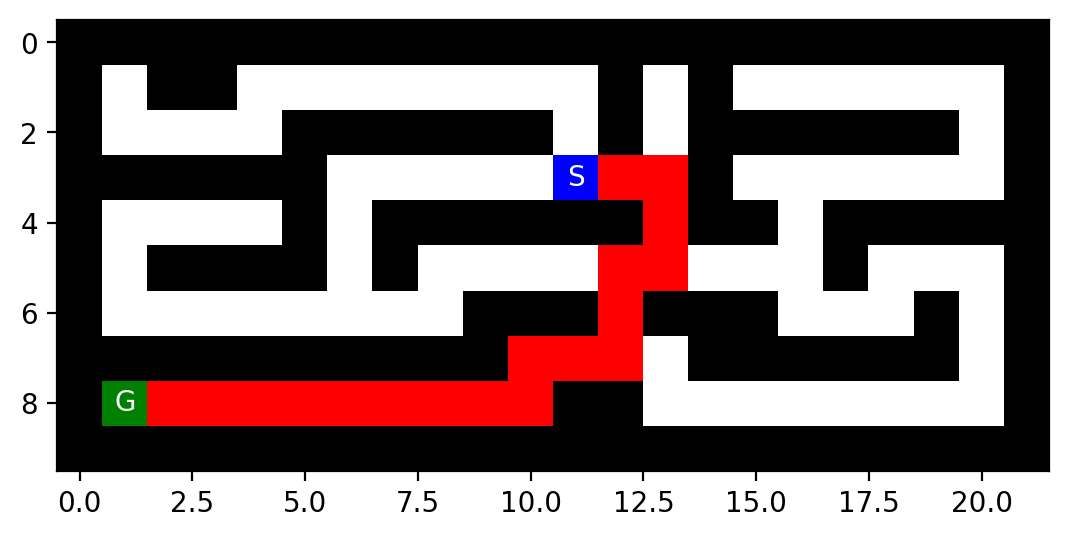

In [16]:
# Your code goes here
# ==== 1. Import và hàm từ maze_helper ====
import maze_helper as mh
import numpy as np
import heapq

# ==== 2. Các hàm hỗ trợ ====

# Heuristic Manhattan
def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Sinh các trạng thái con
def get_neighbors(state, maze):
    x, y = state
    moves = [(1,0), (-1,0), (0,1), (0,-1)]
    neighbors = []
    for dx, dy in moves:
        nx, ny = x + dx, y + dy
        if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1]:
            if maze[nx, ny] != "X":  # không phải tường
                neighbors.append((nx, ny))
    return neighbors

# Đánh dấu đường đi trên maze để hiển thị
def mark_path(maze, path):
    maze_copy = np.copy(maze)
    for (x, y) in path[1:-1]:  # bỏ start và goal
        maze_copy[x, y] = "P"
    return maze_copy

# ==== 3. Greedy Best-First Search ====
def greedy_best_first(start, goal, successors):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), start))
    parent = {start: None}
    reached = {start}

    while frontier:
        _, state = heapq.heappop(frontier)
        if state == goal:
            # reconstruct path
            path = []
            while state is not None:
                path.append(state)
                state = parent[state]
            return list(reversed(path))

        for child in successors(state):
            if child not in reached:
                reached.add(child)
                parent[child] = state
                heapq.heappush(frontier, (manhattan_distance(child, goal), child))
    return None

# ==== 4. A* Search ====
def a_star(start, goal, successors):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), 0, start))
    parent = {start: None}
    g_cost = {start: 0}

    while frontier:
        f, g, state = heapq.heappop(frontier)
        if state == goal:
            # reconstruct path
            path = []
            while state is not None:
                path.append(state)
                state = parent[state]
            return list(reversed(path))

        for child in successors(state):
            new_g = g + 1  # mỗi bước cost = 1
            if child not in g_cost or new_g < g_cost[child]:
                g_cost[child] = new_g
                parent[child] = state
                f = new_g + manhattan_distance(child, goal)
                heapq.heappush(frontier, (f, new_g, child))
    return None

# ==== 5. Load maze có sẵn ====
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)

start = tuple(map(int, mh.find_pos(maze, "S")))
goal = tuple(map(int, mh.find_pos(maze, "G")))

print("Start:", start, "Goal:", goal)
mh.show_maze(maze)

# ==== 6. Chạy Greedy và A* ====
path_greedy = greedy_best_first(start, goal, lambda s: get_neighbors(s, maze))
path_astar = a_star(start, goal, lambda s: get_neighbors(s, maze))

print("Greedy Best-First path length:", len(path_greedy) if path_greedy else None)
print("A* path length:", len(path_astar) if path_astar else None)

# ==== 7. Hiển thị kết quả ====
if path_greedy:
    print("=== Greedy Best-First ===")
    mh.show_maze(mark_path(maze, path_greedy))

if path_astar:
    print("=== A* Search ===")
    mh.show_maze(mark_path(maze, path_astar))


Are your implementations complete and optimal? What is the time and space complexity?

In [90]:
# Discussion

Discussion:

- Greedy Best-First Search:
  + Complete: không hoàn chỉnh, có thể bị kẹt nếu heuristic dẫn sai hướng.
  + Optimal: không đảm bảo tối ưu.
  + Time complexity: O(b^m) trong trường hợp xấu, nhưng thực tế thường nhanh hơn BFS.
  + Space complexity: lưu frontier bằng priority queue, O(b^m).

- A* Search:
  + Complete: có, nếu heuristic là admissible (không vượt quá chi phí thật).
  + Optimal: có, nếu heuristic admissible và consistent.
  + Time complexity: O(b^d) trong trường hợp tốt nhất, nhưng xấu hơn khi heuristic kém.
  + Space complexity: cũng O(b^d), cần lưu frontier và chi phí g.

- So sánh:
  + Greedy nhanh hơn, ít mở rộng hơn nhưng không đảm bảo tối ưu.
  + A* chậm hơn, tốn bộ nhớ nhưng đảm bảo lời giải tối ưu.


## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [17]:
# Add code
import heapq
from collections import deque

# ==== BFS with stats ====
def bfs_stats(start, goal, successors):
    frontier = deque([start])
    parent = {start: None}
    reached = {start}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_nodes_in_memory = 1

    while frontier:
        state = frontier.popleft()
        nodes_expanded += 1

        # depth
        depth = 0
        cur = state
        while parent[cur] is not None:
            cur = parent[cur]
            depth += 1
        max_depth = max(max_depth, depth)

        if state == goal:
            path = []
            while state is not None:
                path.append(state)
                state = parent[state]
            path = list(reversed(path))
            return {
                "path_cost": len(path),
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_nodes_in_memory,
                "max_frontier_size": max_frontier_size
            }

        for child in successors(state):
            if child not in reached:
                reached.add(child)
                parent[child] = state
                frontier.append(child)

        max_frontier_size = max(max_frontier_size, len(frontier))
        max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(reached))

    return None


# ==== DFS with stats ====
def dfs_stats(start, goal, successors):
    stack = [(start, [start])]
    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_nodes_in_memory = 1

    visited_in_path = set()

    while stack:
        state, path = stack.pop()
        nodes_expanded += 1
        max_depth = max(max_depth, len(path))

        if state == goal:
            return {
                "path_cost": len(path),
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_nodes_in_memory,
                "max_frontier_size": max_frontier_size
            }

        if state in visited_in_path:
            continue
        visited_in_path.add(state)

        for child in successors(state):
            if child not in path:  # cycle check
                stack.append((child, path + [child]))

        max_frontier_size = max(max_frontier_size, len(stack))
        max_nodes_in_memory = max(max_nodes_in_memory, len(stack) + len(visited_in_path))

    return None


# ==== Greedy Best-First Search with stats ====
def greedy_stats(start, goal, successors):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), start, [start]))
    reached = {start}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_nodes_in_memory = 1

    while frontier:
        _, state, path = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, len(path))

        if state == goal:
            return {
                "path_cost": len(path),
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_nodes_in_memory,
                "max_frontier_size": max_frontier_size
            }

        for child in successors(state):
            if child not in reached:
                reached.add(child)
                heapq.heappush(frontier, (manhattan_distance(child, goal), child, path + [child]))

        max_frontier_size = max(max_frontier_size, len(frontier))
        max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(reached))

    return None


# ==== A* Search with stats ====
def astar_stats(start, goal, successors):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal), 0, start, [start]))
    g_cost = {start: 0}

    nodes_expanded = 0
    max_frontier_size = 1
    max_depth = 0
    max_nodes_in_memory = 1

    while frontier:
        f, g, state, path = heapq.heappop(frontier)
        nodes_expanded += 1
        max_depth = max(max_depth, len(path))

        if state == goal:
            return {
                "path_cost": len(path),
                "nodes_expanded": nodes_expanded,
                "max_tree_depth": max_depth,
                "max_nodes_in_memory": max_nodes_in_memory,
                "max_frontier_size": max_frontier_size
            }

        for child in successors(state):
            new_g = g + 1
            if child not in g_cost or new_g < g_cost[child]:
                g_cost[child] = new_g
                new_f = new_g + manhattan_distance(child, goal)
                heapq.heappush(frontier, (new_f, new_g, child, path + [child]))

        max_frontier_size = max(max_frontier_size, len(frontier))
        max_nodes_in_memory = max(max_nodes_in_memory, len(frontier) + len(g_cost))

    return None


In [18]:
def run_all_algorithms(maze, start, goal):
    return {
        "BFS": bfs_stats(start, goal, lambda s: get_neighbors(s, maze)),
        "DFS": dfs_stats(start, goal, lambda s: get_neighbors(s, maze)),
        "GBS": greedy_stats(start, goal, lambda s: get_neighbors(s, maze)),
        "A*": astar_stats(start, goal, lambda s: get_neighbors(s, maze)),
    }

# Ví dụ chạy trên small_maze
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
maze = mh.parse_maze(maze_str)
start = tuple(map(int, mh.find_pos(maze, "S")))
goal = tuple(map(int, mh.find_pos(maze, "G")))

results = run_all_algorithms(maze, start, goal)

import pandas as pd
df = pd.DataFrame(results).T
print(df)


     path_cost  nodes_expanded  max_tree_depth  max_nodes_in_memory  \
BFS         20              93              19                   96   
DFS         50              74              50                   79   
GBS         30              40              30                   49   
A*          20              54              20                   65   

     max_frontier_size  
BFS                  9  
DFS                  7  
GBS                  5  
A*                   8  


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

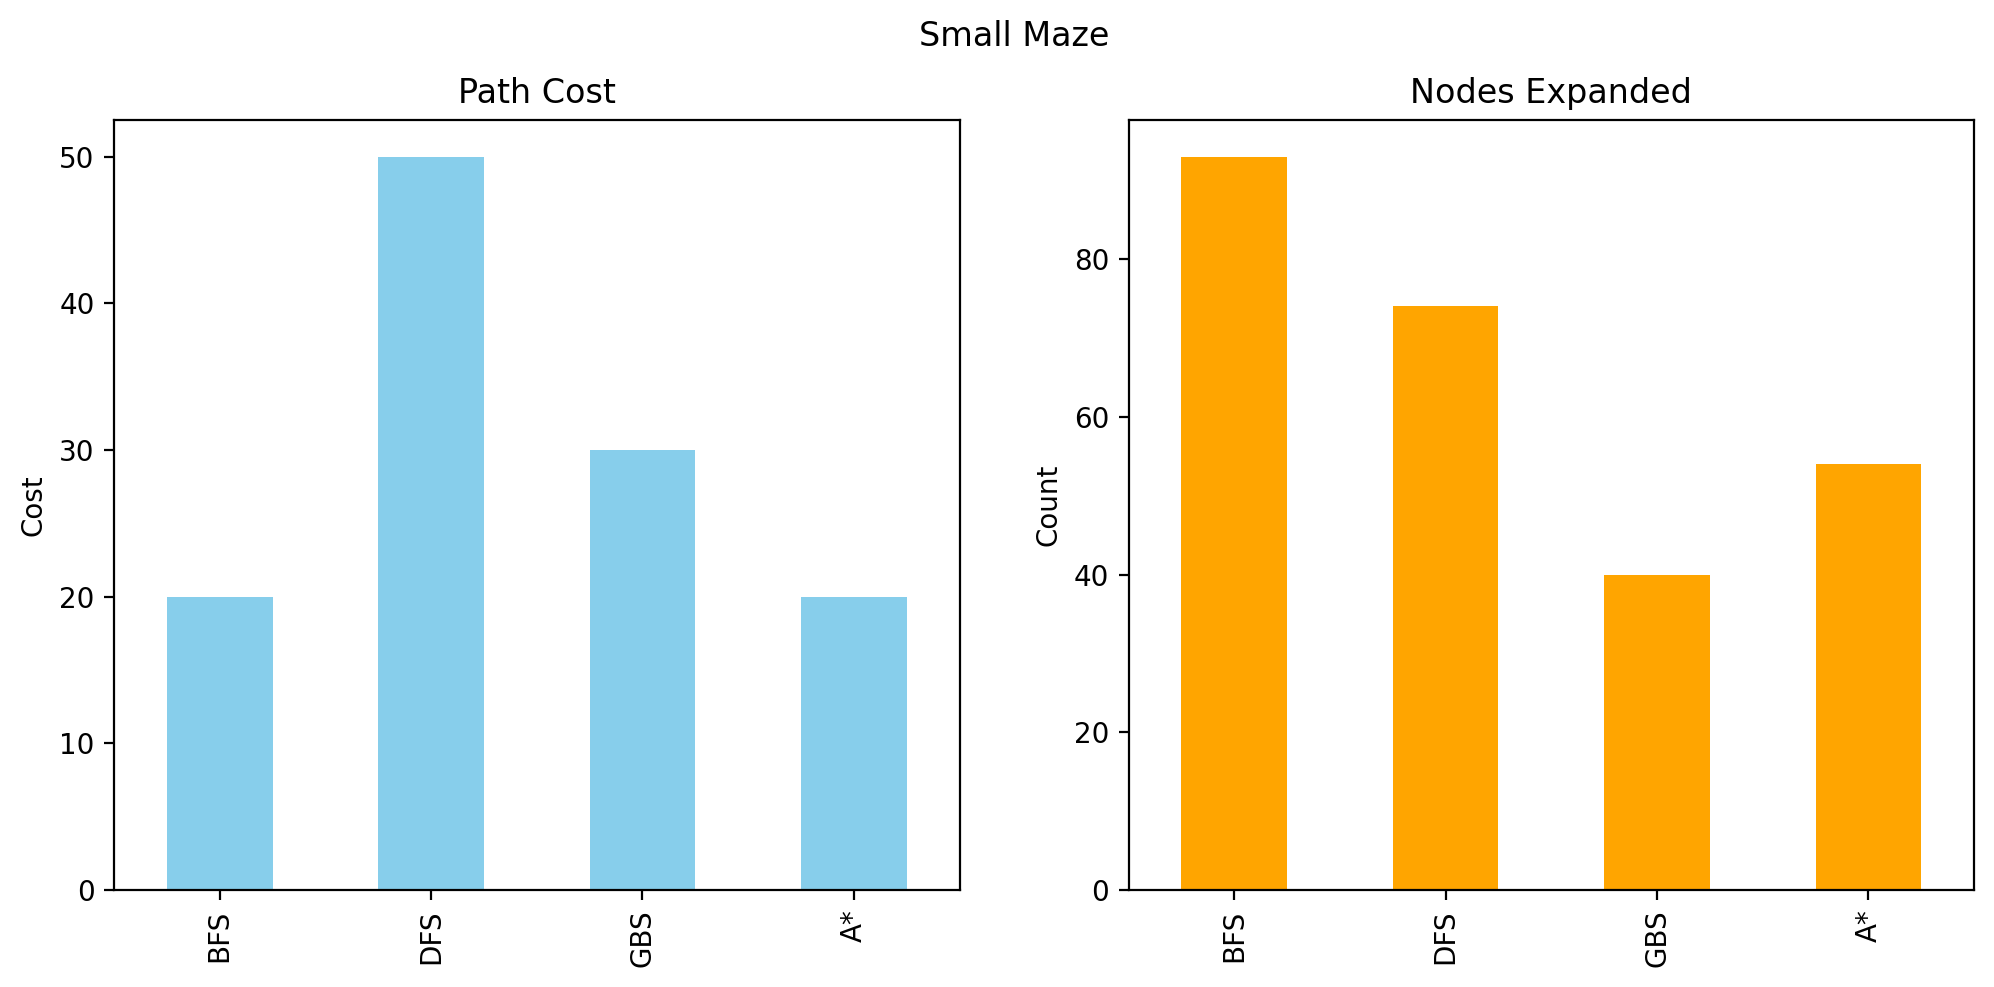

In [19]:
# Add charts
import matplotlib.pyplot as plt

def plot_results(df, title="Comparison of Search Algorithms"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Vẽ path cost
    df["path_cost"].plot(kind="bar", ax=axes[0], color="skyblue")
    axes[0].set_title("Path Cost")
    axes[0].set_ylabel("Cost")

    # Vẽ số node mở rộng
    df["nodes_expanded"].plot(kind="bar", ax=axes[1], color="orange")
    axes[1].set_title("Nodes Expanded")
    axes[1].set_ylabel("Count")

    plt.suptitle(title)
    plt.show()

# Giả sử df là bảng kết quả bạn có từ run_all_algorithms
plot_results(df, title="Small Maze")


Discuss the most important lessons you have learned from implementing the different search strategies. 

In [93]:
# Add discussion

Discussion:

- BFS luôn tìm được đường đi ngắn nhất nhưng rất tốn bộ nhớ.
- DFS dùng ít bộ nhớ nhưng dễ bị kẹt ở nhánh sâu hoặc chu kỳ.
- Greedy Best-First Search chạy nhanh, ít mở rộng node nhưng không đảm bảo tìm đường đi tối ưu.
- A* Search kết hợp cost thực tế và heuristic nên vừa hoàn chỉnh vừa tối ưu, tuy nhiên vẫn tiêu tốn nhiều bộ nhớ.
- Nhìn vào chart có thể thấy BFS và A* mở rộng nhiều node hơn DFS và Greedy, nhưng A* thường cho path cost ngắn nhất.


## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

In [20]:
# Your code/answer goes here
def dls(state, goal, successors, limit, path):
    if state == goal:
        return path
    if limit <= 0:
        return None
    for child in successors(state):
        if child not in path:  # tránh cycle
            result = dls(child, goal, successors, limit-1, path+[child])
            if result is not None:
                return result
    return None

def ids(start, goal, successors, max_depth=1000):
    for depth in range(max_depth):
        result = dls(start, goal, successors, depth, [start])
        if result is not None:
            return result
    return None

# Ví dụ chạy IDS
path_ids = ids(start, goal, lambda s: get_neighbors(s, maze), max_depth=50)
print("IDS path length:", len(path_ids) if path_ids else None)


IDS path length: 20


### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [21]:
# Your code/answer goes here
def bfs_multi(start, goals, successors):
    from collections import deque
    frontier = deque([start])
    parent = {start: None}
    reached = {start}

    while frontier:
        state = frontier.popleft()
        if state in goals:
            # reconstruct path
            path = []
            while state is not None:
                path.append(state)
                state = parent[state]
            return list(reversed(path))

        for child in successors(state):
            if child not in reached:
                reached.add(child)
                parent[child] = state
                frontier.append(child)
    return None

# Ví dụ:
goals = {tuple(map(int, mh.find_pos(maze, "G"))), (5, 5)}  # nhiều goal
path = bfs_multi(start, goals, lambda s: get_neighbors(s, maze))
print("Path length:", len(path) if path else None)


Path length: 20


## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [23]:
# Your code/answer goes here
def is_intersection(maze, x, y):
    if maze[x, y] == "X":
        return False
    moves = [(1,0), (-1,0), (0,1), (0,-1)]
    count = 0
    for dx, dy in moves:
        nx, ny = x+dx, y+dy
        if 0 <= nx < maze.shape[0] and 0 <= ny < maze.shape[1]:
            if maze[nx, ny] != "X":
                count += 1
    return count != 2  # ngõ cụt, ngã ba, ngã tư, hoặc start/goal

def build_intersection_graph(maze, start, goal):
    intersections = []
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if is_intersection(maze, i, j) or (i,j) in [start, goal]:
                intersections.append((i,j))

    graph = {node: {} for node in intersections}
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    for node in intersections:
        for dx, dy in directions:
            path = []
            x, y = node
            steps = 0
            while True:
                x, y = x+dx, y+dy
                if not (0 <= x < maze.shape[0] and 0 <= y < maze.shape[1]):
                    break
                if maze[x, y] == "X":
                    break
                steps += 1
                if (x, y) in intersections:
                    graph[node][(x,y)] = steps
                    break
    return graph

# Ví dụ chạy
graph = build_intersection_graph(maze, start, goal)
print(graph)


{(1, 1): {}, (1, 13): {(3, 13): 2}, (1, 15): {}, (3, 11): {(3, 13): 2}, (3, 13): {(5, 13): 2, (1, 13): 2, (3, 11): 2}, (3, 15): {(3, 16): 1}, (3, 16): {(5, 16): 2, (3, 15): 1}, (4, 4): {}, (5, 12): {(7, 12): 2, (5, 13): 1}, (5, 13): {(3, 13): 2, (5, 16): 3, (5, 12): 1}, (5, 16): {(3, 16): 2, (5, 13): 3}, (6, 6): {}, (7, 12): {(5, 12): 2}, (8, 1): {}}


### Intersection as States

- Thay vì coi mỗi ô trong mê cung là một state, ta chỉ coi **các ngã ba, ngõ cụt và goal/start** là state.
- Giữa các intersection, ta coi hành lang là một cạnh (edge) có trọng số bằng số ô đi qua.

- Ưu điểm:
  + Giảm rất nhiều số lượng state → tiết kiệm bộ nhớ.
  + Tìm kiếm nhanh hơn trên đồ thị nhỏ gọn.

- Vấn đề:
  + Đường đi giữa các intersection có chi phí khác nhau, nên cần gán **path cost chính xác** theo độ dài hành lang.
  + Nếu chỉ dùng BFS theo số bước "giữa intersection" thì không còn tối ưu.
  + Để vẫn đảm bảo optimal:
    * BFS phải dùng với chi phí đồng nhất trên cạnh (nếu coi mỗi bước đi trong hành lang là 1 cost).
    * Hoặc dùng **Uniform Cost Search** (Dijkstra/A\*) với trọng số thật.

- Kết luận: 
  + Dùng intersection làm state giúp tiết kiệm tài nguyên.
  + Nhưng để vẫn tối ưu, BFS thường không còn đủ, thay vào đó nên dùng Uniform Cost Search hoặc A* với chi phí thực.


### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [22]:
# Your code/answer goes here
def weighted_astar(start, goal, successors, w=2):
    frontier = []
    heapq.heappush(frontier, (manhattan_distance(start, goal)*w, 0, start, [start]))
    g_cost = {start: 0}

    while frontier:
        f, g, state, path = heapq.heappop(frontier)
        if state == goal:
            return path

        for child in successors(state):
            new_g = g + 1
            if child not in g_cost or new_g < g_cost[child]:
                g_cost[child] = new_g
                new_f = new_g + w * manhattan_distance(child, goal)
                heapq.heappush(frontier, (new_f, new_g, child, path + [child]))
    return None

# Thử chạy
path_wastar = weighted_astar(start, goal, lambda s: get_neighbors(s, maze), w=2)
print("Weighted A* path length:", len(path_wastar))


Weighted A* path length: 20


### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [98]:
# Your code/answer goes here

Khi agent không biết trước bản đồ mê cung thì agent đang ở trong môi trường chưa biết (unknown environment). Điều này có nghĩa là nó không biết luật chuyển trạng thái (transition function) mà phải vừa đi vừa khám phá.

PEAS:

Performance: tìm được goal nhanh, chi phí ít.

Environment: mê cung chưa biết trước.

Actuators: di chuyển lên, xuống, trái, phải.

Sensors: biết được tình trạng các ô lân cận sau khi di chuyển, nếu có GPS thì biết khoảng cách đến goal.

Cách xây dựng agent hợp lý:

Agent sẽ vừa đi vừa xây dựng lại bản đồ đã khám phá.

Có thể dùng thuật toán Online DFS hoặc LRTA* để vừa khám phá vừa tìm đường.

Nếu có GPS báo khoảng cách thì agent dùng nó như heuristic để hướng đi.

Agent cần lưu lại các ô đã đi để tránh vòng lặp.